### Importing Libraries

In [1]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import sys
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from mpl_toolkits.mplot3d import axes3d

from tqdm import tqdm

# Load image
import imageio

# Set random seed so output is all same
np.random.seed(1)

## K Means Implementation

The K-means algorithm is a method for dividing a set of data points into distinct clusters, or groups, based on similar attributes. It is an unsupervised learning algorithm which means it does not require labeled data in order to find patterns in the dataset.

This method of comparing similarity is called Euclidean distance. Another commonly used similarity function in K-means clustering is called Manhattan distance.

K-means is an example of a partitional clustering algorithm (also known as centroid-based clustering). This means that it takes in a user supplied amount of clusters, k, and divides the data into that many partitions. In partitional clustering, each data point can only belong to a single cluster and no cluster can be empty.

Many partitional clustering algorithms are non-deterministic. This means that if you could end up with different clusters each time you run the algorithm even if you keep the inputs fixed.



In [2]:
class KMeans(object):

    def __init__(self):
        pass

    def pairwise_dist(self, x, y): 
        """
        Args:
            x: N x D numpy array
            y: M x D numpy array
        Return:
                dist: N x M array, where dist2[i, j] is the euclidean distance between 
                x[i, :] and y[j, :]
                """
        xSumSquare = np.sum(np.square(x),axis=1);
        ySumSquare = np.sum(np.square(y),axis=1);
        mul = np.dot(x, y.T);
        dists = np.sqrt(abs(xSumSquare[:, np.newaxis] + ySumSquare-2*mul))
        return dists

    def _init_centers(self, points, K, **kwargs):
        """
        Args:
            points: NxD numpy array, where N is # points and D is the dimensionality
            K: number of clusters
            kwargs: any additional arguments you want
        Return:
            centers: K x D numpy array, the centers. 
        """
        row, col = points.shape
        retArr = np.empty([K, col])
        for number in range(K):
            randIndex = np.random.randint(row)
            retArr[number] = points[randIndex]
        
        return retArr

    def _update_assignment(self, centers, points): 
        """
        Args:
            centers: KxD numpy array, where K is the number of clusters, and D is the dimension
            points: NxD numpy array, the observations
        Return:
            cluster_idx: numpy array of length N, the cluster assignment for each point

        Hint: You could call pairwise_dist() function.
        """
        row, col = points.shape
        cluster_idx = np.empty([row])
        distances = self.pairwise_dist(points, centers)
        cluster_idx = np.argmin(distances, axis=1)

        return cluster_idx

    def _update_centers(self, old_centers, cluster_idx, points):  
        """
        Args:
            old_centers: old centers KxD numpy array, where K is the number of clusters, and D is the dimension
            cluster_idx: numpy array of length N, the cluster assignment for each point
            points: NxD numpy array, the observations
        Return:
            centers: new centers, K x D numpy array, where K is the number of clusters, and D is the dimension.
        """
        K, D = old_centers.shape
        new_centers = np.empty(old_centers.shape)
        for i in range(K):
            new_centers[i] = np.mean(points[cluster_idx == i], axis = 0)
        return new_centers

    def _get_loss(self, centers, cluster_idx, points):  
        """
        Args:
            centers: KxD numpy array, where K is the number of clusters, and D is the dimension
            cluster_idx: numpy array of length N, the cluster assignment for each point
            points: NxD numpy array, the observations
        Return:
            loss: a single float number, which is the objective function of KMeans. 
        """
        dists = self.pairwise_dist(points, centers)
        loss = 0.0
        N, D = points.shape
        for i in range(N):
            loss = loss + np.square(dists[i][cluster_idx[i]])
        
        return loss

    def __call__(self, points, K, max_iters=100, abs_tol=1e-16, rel_tol=1e-16, verbose=False, **kwargs):
        """
        Args:
            points: NxD numpy array, where N is # points and D is the dimensionality
            K: number of clusters
            max_iters: maximum number of iterations (Hint: You could change it when debugging)
            abs_tol: convergence criteria w.r.t absolute change of loss
            rel_tol: convergence criteria w.r.t relative change of loss
            verbose: boolean to set whether method should print loss (Hint: helpful for debugging)
            kwargs: any additional arguments you want
        Return:
            cluster assignments: Nx1 int numpy array
            cluster centers: K x D numpy array, the centers
            loss: final loss value of the objective function of KMeans
        """
        centers = self._init_centers(points, K, **kwargs)
        for it in range(max_iters):
            cluster_idx = self._update_assignment(centers, points)
            centers = self._update_centers(centers, cluster_idx, points)
            loss = self._get_loss(centers, cluster_idx, points)
            K = centers.shape[0]
            if it:
                diff = np.abs(prev_loss - loss)
                if diff < abs_tol and diff / prev_loss < rel_tol:
                    break
            prev_loss = loss
            if verbose:
                print('iter %d, loss: %.4f' % (it, loss))
        return cluster_idx, centers, loss

In [3]:
def find_optimal_num_clusters(self, data, max_K=15):
    """
    Plots loss values for different number of clusters in K-Means

    Args:
        image: input image of shape(H, W, 3)
        max_K: number of clusters
    Return:
        None (plot loss values against number of clusters)
    """
    y_val = np.empty(max_K)

    for i in range(max_K):
        cluster_idx, centers, y_val[i] = KMeans()(data, i + 1)

    plt.plot(np.arange(max_K) + 1, y_val)
    plt.show()
    return y_val

### Performing Image Segmentation using K-means algorithm

One great practical application of the K-means application is for image segmentation. This means grouping an image into k clusters based on their color, thus reducing the image to a limited spectrum of colors. Luckily, we can achieve this with no modifications to our K-means class implementation and just a little bit more code.


In [4]:
def image_to_matrix(image_file, grays=False):
    """
    Convert .png image to matrix
    of values.
    params:
    image_file = str
    grays = Boolean
    returns:
    img = (color) np.ndarray[np.ndarray[np.ndarray[float]]]
    or (grayscale) np.ndarray[np.ndarray[float]]
    """
    img = plt.imread(image_file)
    # in case of transparency values
    if len(img.shape) == 3 and img.shape[2] > 3:
        height, width, depth = img.shape
        new_img = np.zeros([height, width, 3])
        for r in range(height):
            for c in range(width):
                new_img[r, c, :] = img[r, c, 0:3]
        img = np.copy(new_img)
    if grays and len(img.shape) == 3:
        height, width = img.shape[0:2]
        new_img = np.zeros([height, width])
        for r in range(height):
            for c in range(width):
                new_img[r, c] = img[r, c, 0]
        img = new_img
    return img

In [5]:
image_values = image_to_matrix('images/birds.jpg')

r = image_values.shape[0]
c = image_values.shape[1]
ch = image_values.shape[2]

# flatten the image_values
image_values = image_values.reshape(r*c,ch)

k = 6 # feel free to change this value

cluster_idx, centers, loss = KMeans()(image_values, k)
updated_image_values = np.copy(image_values)

# assign each pixel to cluster mean
for i in range(0,k):
    indices_current_cluster = np.where(cluster_idx == i)[0]
    updated_image_values[indices_current_cluster] = centers[i]
    
updated_image_values = updated_image_values.reshape(r,c,ch)


### Orginal Image

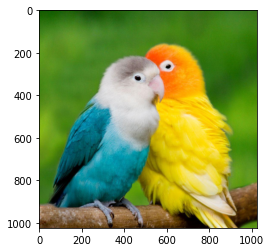

In [6]:
img = mpimg.imread('images/birds.jpg')
imgplot = plt.imshow(img)
plt.show()

### This image has been reduced down to just six colors using the K-means algorithm

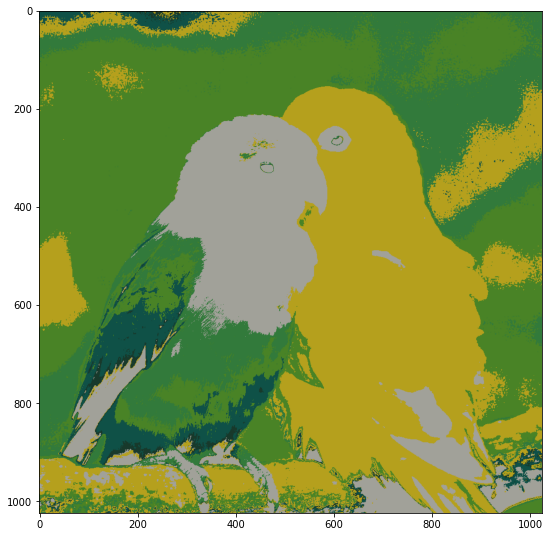

In [7]:
plt.figure(None,figsize=(9,12))
plt.imshow(updated_image_values)
plt.show()